##  Arboles de decisión

A continuación procedemos con un ejemplo de un árbol construido desde cero y su implementación en Sklearn 

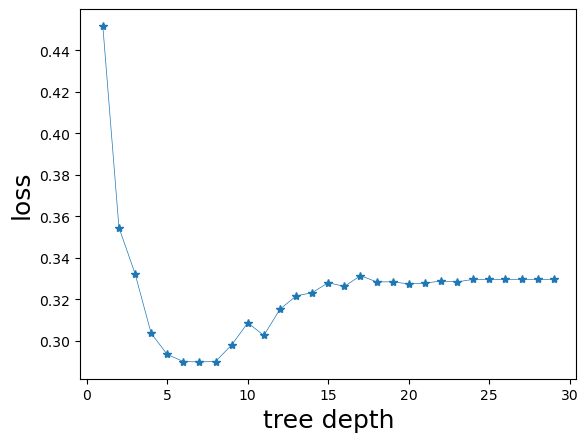

In [1]:
""" Tree Depth CV """
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt

def ZeroOneScore(clf, X, y):
    y_pred = clf.predict(X)
    return zero_one_loss(y, y_pred)


# Construct the training set 
X, y =  make_blobs(n_samples=5000, n_features=10, centers=3,
                           random_state=10, cluster_std=10)
    
# construct a decision tree classifier  
clf = DecisionTreeClassifier(random_state=0)

# cross validation loss as a function of tree depth (1 to 30)
xdepthlist = []
cvlist = []
tree_depth = range(1,30)
for d in tree_depth:
    xdepthlist.append(d)
    clf.max_depth=d
    cv = np.mean(cross_val_score(clf, X, y, cv=10, scoring=ZeroOneScore))
    cvlist.append(cv)
    
plt.xlabel('tree depth', fontsize=18, color='black')
plt.ylabel('loss', fontsize=18, color='black')
plt.plot(xdepthlist, cvlist,'-*' , linewidth=0.5)

In [2]:
""" BasicTree  """
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split

def makedata():
  n_points = 500 # points
 
  X, y =  make_friedman1(n_samples=n_points, n_features=5, 
                         noise=1.0, random_state=100)
         
  return train_test_split(X, y, test_size=0.5, random_state=3)
  
 
def main():
  X_train, X_test, y_train, y_test = makedata()    
  maxdepth = 10 # maximum tree depth             
  # Create tree root at depth 0                       
  treeRoot = TNode(0, X_train,y_train) 
       
  # Build the regression tree with maximal depth equal to max_depth
  Construct_Subtree(treeRoot, maxdepth) 
    
  # Predict
  y_hat = np.zeros(len(X_test))
  for i in range(len(X_test)):
     y_hat[i] = Predict(X_test[i],treeRoot)          
    
  MSE = np.mean(np.power(y_hat - y_test,2))    
  print("Basic tree: tree loss = ",  MSE)

# tree node
class TNode:
   def __init__(self, depth, X, y): 
      self.depth = depth
      self.X = X   # matrix of explanatory variables
      self.y = y   # vector of response variables
      # initialize optimal split parameters
      self.j = None
      self.xi = None
      # initialize children to be None      
      self.left = None
      self.right = None
      # initialize the regional predictor
      self.g = None
      
   def CalculateLoss(self):
       if(len(self.y)==0):
           return 0
       
       return np.sum(np.power(self.y- self.y.mean(),2))
                    
  
def Construct_Subtree(node, max_depth):  
    if(node.depth == max_depth or len(node.y) == 1):
        node.g  = node.y.mean()
    else:
        j, xi = CalculateOptimalSplit(node)               
        node.j = j
        node.xi = xi
        Xt, yt, Xf, yf = DataSplit(node.X, node.y, j, xi)
              
        if(len(yt)>0):
            node.left = TNode(node.depth+1,Xt,yt)
            Construct_Subtree(node.left, max_depth)
        
        if(len(yf)>0):        
            node.right = TNode(node.depth+1, Xf,yf)
            Construct_Subtree(node.right, max_depth)      
     
    return node

# split the data-set
def DataSplit(X,y,j,xi):
    ids = X[:,j]<=xi      
    Xt  = X[ids == True,:]
    Xf  = X[ids == False,:]
    yt  = y[ids == True]
    yf  = y[ids == False]
    return Xt, yt, Xf, yf             

def CalculateOptimalSplit(node):
    X = node.X
    y = node.y
    best_var = 0
    best_xi = X[0,best_var]          
    best_split_val = node.CalculateLoss()
    
    m, n  = X.shape
    
    for j in range(0,n):
        for i in range(0,m):
            xi = X[i,j]
            Xt, yt, Xf, yf = DataSplit(X,y,j,xi)
            tmpt = TNode(0, Xt, yt) 
            tmpf = TNode(0, Xf, yf) 
            loss_t = tmpt.CalculateLoss()
            loss_f = tmpf.CalculateLoss()    
            curr_val =  loss_t + loss_f
            if (curr_val < best_split_val):
                best_split_val = curr_val
                best_var = j
                best_xi = xi
    return best_var,  best_xi


def Predict(X,node):
    if(node.right == None and node.left != None):
        return Predict(X,node.left)
    
    if(node.right != None and node.left == None):
        return Predict(X,node.right)
    
    if(node.right == None and node.left == None):
        return node.g
    else:
        if(X[node.j] <= node.xi):
            return Predict(X,node.left)
        else:
            return Predict(X,node.right)
    
main()  # run the main program

# compare with sklearn
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = makedata()    
regTree = DecisionTreeRegressor(max_depth = 10, random_state=0)
regTree.fit(X_train,y_train)
y_hat = regTree.predict(X_test)
MSE2 = np.mean(np.power(y_hat - y_test,2))    
print("DecisionTreeRegressor: tree loss = ",  MSE2)     

Basic tree: tree loss =  9.067077996170276
DecisionTreeRegressor: tree loss =  10.19925448488538
